# Quantum Map Spectrum

In [1]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random

import pickle
from qiskit.quantum_info import DensityMatrix
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from src import *
#np.set_printoptions(threshold=sys.maxsize)

## Random Choi Map Spectrum

In [2]:
n = 2
d = 2**n
rank = 2

np.random.seed(42)
choi_target = ChoiMap(d, rank)
input_list = [prepare_input(numberToBase(i, 6, n)) for i in range(6**n)]
target_list = [choi_target.apply_map(state) for state in input_list]
choi_model = ChoiMap(d, rank)
model = ModelQuantumMap(q_map = choi_model,
                        cost = state_density_loss,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.025, 
                        h = 1e-4)

spectrum = choi_spectrum(choi_target.choi)
spectrum1 = choi_spectrum(choi_model.choi)

In [3]:
model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum2 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum3 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam = True,
            verbose = False,
            N = 1)
spectrum4 = choi_spectrum(choi_model.choi)

model.train(num_iter = 100,
            use_adam=True,
            verbose = False,
            N = 1)
spectrum5 = choi_spectrum(choi_model.choi)

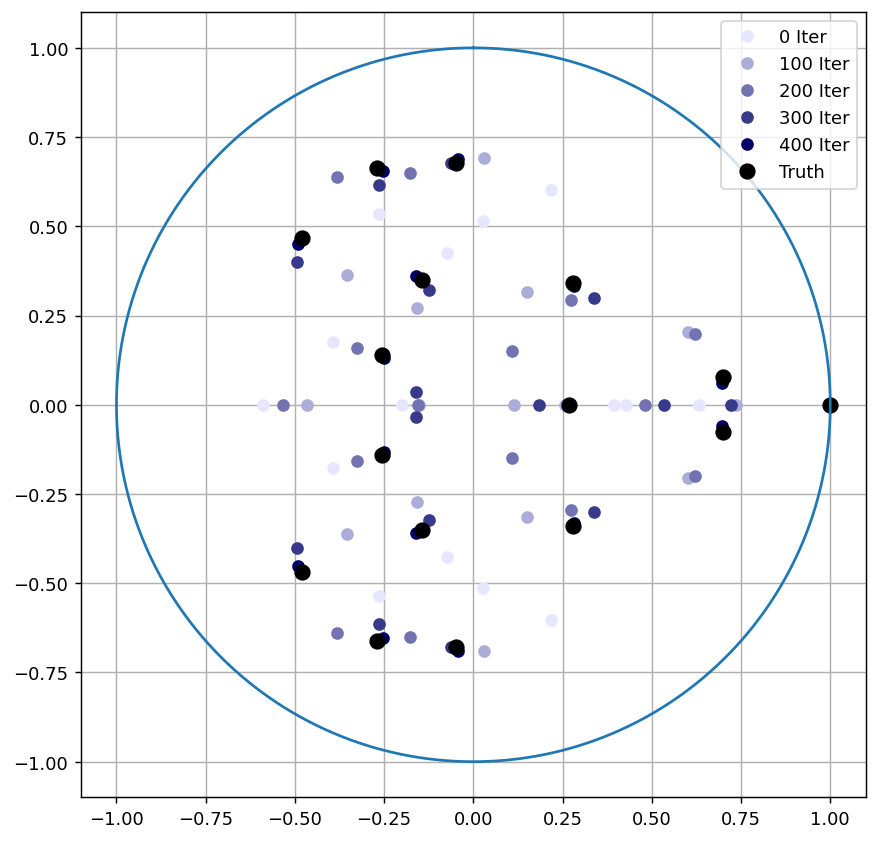

In [4]:
#spectrum_list = np.array([spectrum1, spectrum2, spectrum3, spectrum4, spectrum5, spectrum6, spectrum7])
#print(spectrum_list.shape)
t = np.linspace(0, 2*np.pi, 1000)
circle = [np.sin(t), np.cos(t)]
      
fig = plt.figure(figsize=(12,8), dpi = 130, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)

a = np.linspace(0.9, 0, 5)
b = np.linspace(1, 0.4, 5)

c = list(zip(a, a, b))

plt.plot(spectrum1[0], spectrum1[1], "o", color = c[0], markersize=6)
plt.plot(spectrum2[0], spectrum2[1], "o", color = c[1], markersize=6)
plt.plot(spectrum3[0], spectrum3[1], "o", color = c[2], markersize=6)
plt.plot(spectrum4[0], spectrum4[1], "o", color = c[3], markersize=6)
plt.plot(spectrum5[0], spectrum5[1], "o", color = c[4], markersize=6)



plt.plot(spectrum[0], spectrum[1], "ko", markersize=8)
plt.legend(["0 Iter", "100 Iter", "200 Iter", "300 Iter", "400 Iter", "Truth"], loc="upper right")
plt.plot(*circle)
plt.grid()

plt.show()

In [3]:
def greedy_pair_distance(a_list, b_list):
    connections = []
    not_connected = len(a_list)*[True]
    
    for i, a in enumerate(a_list):
        min_dist = float("inf")
        idx = 0
        for j, b in enumerate(b_list):
            dist = np.linalg.norm(a - b)
            if (dist < min_dist) and not_connected[j]:
                
                min_dist = dist
                idx = j
                
        not_connected[idx] = False     
        connections.append(idx)
    
    return connections
        

def pair_distance(a_list, b_list, connections):
    distance = 0
    for i, idx in enumerate(connections):
        distance += np.linalg.norm(a_list[i] - b_list[idx]) 

    return distance 


def min_pair_distance(a_list, b_list, num_iter = 100, T = 1):
    length = len(a_list)
    connections = greedy_pair_distance(a_list, b_list)
    #connections = list(range(length))
    #random.shuffle(connections)
    distance = pair_distance(a_list, b_list, connections)
    distance_list = [distance]
    
    for i in range(num_iter):
        idx1 = random.randint(0, length-1)
        idx2 = random.randint(0, length-2)
        if idx1 <= idx2:
            idx2 += 1
        
        distance_old = np.linalg.norm(a_list[idx1] - b_list[connections[idx1]]) \
                     + np.linalg.norm(a_list[idx2] - b_list[connections[idx2]])
        distance_new = np.linalg.norm(a_list[idx2] - b_list[connections[idx1]]) \
                     + np.linalg.norm(a_list[idx1] - b_list[connections[idx2]])
        distance_diff = distance_new - distance_old
        
        
        u = random.uniform(0,1)
        if np.exp(-distance_diff/T) > u:
            distance += distance_diff
            connections[idx1], connections[idx2] = connections[idx2], connections[idx1]
        
        distance_list.append(distance)
        
    return connections, distance_list

In [60]:
#T = 0
random.seed(42)
np.random.seed(42)
n = 16
a_list = [np.random.normal(0, 1, 2) for i in range(n)]
b_list = [np.random.normal(0, 1, 2) for i in range(n)]
connections1, distance_list1 = min_pair_distance(a_list, b_list, num_iter = 1000, T = 0)

#T = 0.1
random.seed(42)
np.random.seed(42)
n = 16
a_list = [np.random.normal(0, 1, 2) for i in range(n)]
b_list = [np.random.normal(0, 1, 2) for i in range(n)]
connections2, distance_list2 = min_pair_distance(a_list, b_list, num_iter = 1000, T = 0.1)

<ipython-input-35-4c5be20463e9>:51: RuntimeWarning: divide by zero encountered in double_scalars
  if np.exp(-distance_diff/T) > u:


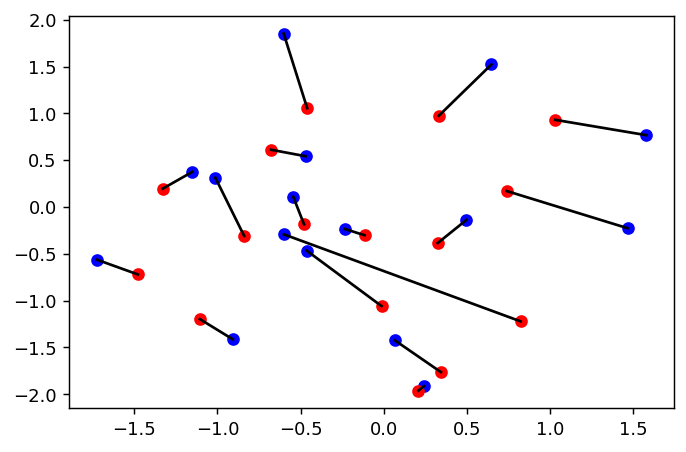

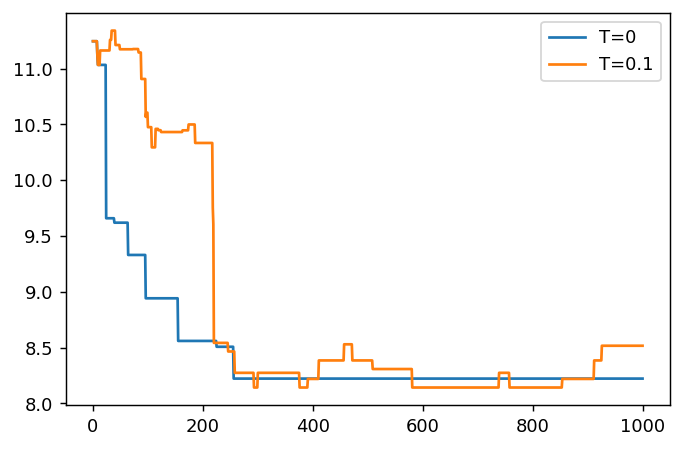

In [61]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(*list(zip(*a_list)), "bo")
plt.plot(*list(zip(*b_list)), "ro")
for i in range(n):
    coords = list(zip(a_list[i], b_list[connections1[i]]))
    plt.plot(*coords, "k")
plt.show()

fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(distance_list1)
plt.plot(distance_list2)
#plt.ylim([40, 80])
plt.legend(["T=0", "T=0.1"])
plt.show()

In [62]:
n = 1
d = 2**n
rank = 2

np.random.seed(42)
choi1 = ChoiMap(d, rank)
choi2 = ChoiMap(d, rank)

spectrum1 = choi_spectrum(choi1.choi)
spectrum2 = choi_spectrum(choi2.choi)


spectrum1 = [np.array((a,b)) for a,b in zip(*spectrum1)]
spectrum2 = [np.array((a,b)) for a,b in zip(*spectrum2)]
N = len(spectrum1)

In [63]:
connections, distance_list = min_pair_distance(spectrum1, spectrum2, num_iter = 10000, T = 0.01)

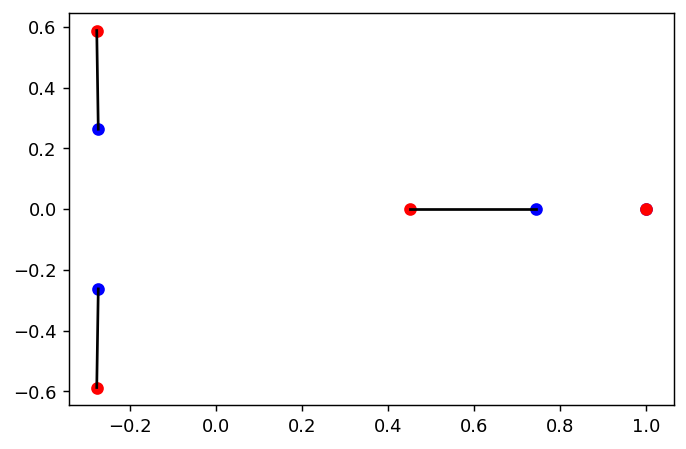

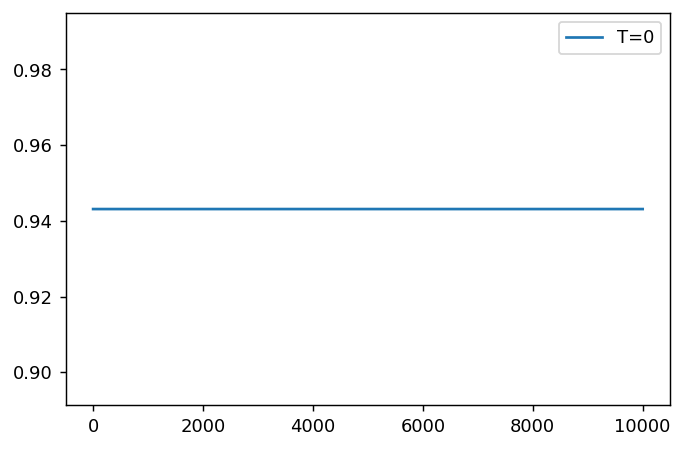

In [64]:
fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(*list(zip(*spectrum1)), "bo")
plt.plot(*list(zip(*spectrum2)), "ro")

for i in range(N):
    coords = list(zip(spectrum1[i], spectrum2[connections[i]]))
    plt.plot(*coords, "k")
plt.show()

fig=plt.figure(figsize=(6,4), dpi = 130, facecolor='w', edgecolor='k')
plt.plot(distance_list)
plt.legend(["T=0", "T=0.1"])
plt.show()

## Fit Model to Spectrum

In [19]:
def spectrum_distance(q_map, input, target):
    choi_model = maps_to_choi([q_map])
    
    q_map_target = input
    choi_target = maps_to_choi([q_map_target])
    
    spectrum_model = [np.array((a,b)) for a,b in zip(*choi_spectrum(choi_model))]
    spectrum_target = [np.array((a,b)) for a,b in zip(*choi_spectrum(choi_target))]
    _, distance_list = min_pair_distance(spectrum_model, spectrum_target, num_iter = 2000, T = 0.02)
    cost = distance_list[-1]
    
    return cost

In [20]:
n = 2
d = 2**n
rank = 2

np.random.seed(42)
random.seed(42)
choi_target = ChoiMap(d, rank)
spectrum_target = choi_spectrum(choi_target.choi)

choi_model = ChoiMap(d, rank)


input_list = [choi_target]
target_list = [None]

model = ModelQuantumMap(q_map = choi_model,
                        cost = spectrum_distance,
                        input_list = input_list,
                        target_list = target_list,
                        lr = 0.01, 
                        h = 1e-3)

In [ ]:
model.train(num_iter = 1000,
            use_adam = True,
            verbose = True)

spectrum_model = choi_spectrum(choi_model.choi)

0: fid: 2.949, c: 0.000
1: fid: 2.806, c: 0.000
2: fid: 2.708, c: 0.000
3: fid: 2.639, c: 0.000
4: fid: 2.580, c: 0.000
5: fid: 2.530, c: 0.000
6: fid: 2.489, c: 0.000
7: fid: 2.453, c: 0.000
8: fid: 2.423, c: 0.000
9: fid: 2.396, c: 0.000
10: fid: 2.372, c: 0.000
11: fid: 2.357, c: 0.000
12: fid: 2.357, c: 0.000
13: fid: 2.336, c: 0.000
14: fid: 2.313, c: 0.000
15: fid: 2.292, c: 0.000
16: fid: 2.271, c: 0.000
17: fid: 2.254, c: 0.000
18: fid: 2.241, c: 0.000
19: fid: 2.226, c: 0.000
20: fid: 2.208, c: 0.000
21: fid: 2.191, c: 0.000
22: fid: 2.174, c: 0.000
23: fid: 2.159, c: 0.000
24: fid: 2.144, c: 0.000
25: fid: 2.130, c: 0.000
26: fid: 2.116, c: 0.000


0.08163475549519586


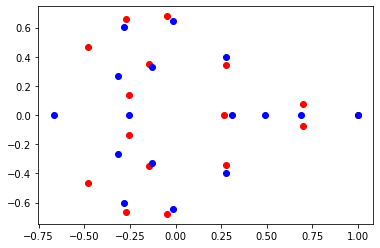

In [15]:
print(channel_fidelity(choi_target, choi_model))

spectrum_model = choi_spectrum(choi_model.choi)

plt.plot(*spectrum_target, "ro")
plt.plot(*spectrum_model, "bo")
plt.show()